# (1) Data Preparation


In [39]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

np.random.seed(777)

diabetes_untouched = pd.read_csv("data/diabetes.csv")
diabetes_untouched.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Dataset has 8 features that it tracks: 
* Number of pregnancies
* Glucose levels
* Blood Pressure (diastolic only)
* Tricep skin fold thickness
* Insulin levels
* BMI (Body Mass Index)
* Diabetes Pedigree Function
* Age

The data set tracks the `Outcome` 
* 0 indicates tested negative for type 2 diabetes
* 1 indicates tested positve for type 2 diabetes


In [40]:
diabetes_untouched.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [41]:
len(diabetes_untouched)

768

**There are 768 records in dataset:**
`diabetes_untouched` will hold these records

**NOTICE**: there are zero in the dataset. These will be converted to numpy NaN as to be easier to work with built in functions. All data is numerical and no encoding is needed.

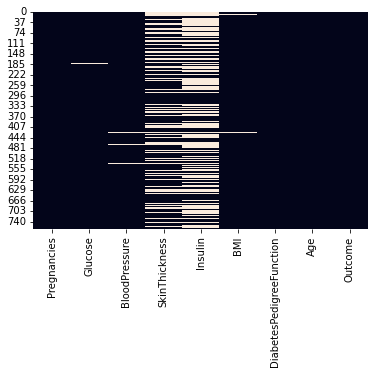

In [42]:
features_to_impute =["Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]
diabetes_untouched[features_to_impute] = diabetes_untouched[features_to_impute].replace({'0':np.nan, 0:np.nan})

sns.heatmap(diabetes_untouched.isnull(), cbar = False);

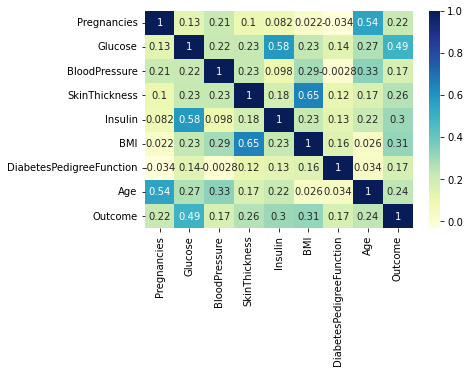

In [43]:

cor_matrix = sns.heatmap(diabetes_untouched.corr(),annot= True, cmap="YlGnBu");

Heatmap shows that there may be a strong correlation between glucose and outcome.  Moderate to low correlation with BMI, Insulin, Skin thickness.  Weaker correlation with age, pedigree, blood pressure, and number of pregnancies.

This may be used later with a Regression model to narrow down important features

# (2) Splitting the data


In [44]:
X = diabetes_untouched.drop("Outcome", axis = 1)
y = diabetes_untouched["Outcome"]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# (3) Preprocessing data

### Imputing by mean 

In [45]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Strategy
num_imputer = SimpleImputer(strategy = "mean")

imputer = ColumnTransformer([
    ("num_imputer",num_imputer, features_to_impute)])

mean_X_train = imputer.fit_transform(X_train) # fit_transform imputes the missing values from the training set and fills them simultaneously
mean_X_test = imputer.transform(X_test)  #tranform takes the imputing missing values from the training set and fills the test set with them



**Creating seperate X_train, X_test that only uses features that the average person could collect at home**

In [46]:
real_world_features = ["Pregnancies","Glucose","BloodPressure","BMI","Age"]


X_train_reduced = X_train.drop(["Insulin","SkinThickness","DiabetesPedigreeFunction"], axis= 1)
X_test_reduced = X_test.drop(["Insulin","SkinThickness","DiabetesPedigreeFunction"], axis = 1)

imputer_real =  ColumnTransformer([
    ("num_imputer",num_imputer, real_world_features)])

real_world_mean_X_train = imputer_real.fit_transform(X_train_reduced)
real_world_mean_X_test = imputer_real.transform(X_test_reduced)





### Imputing by dropping records with missing values

In [47]:
cols_missing_data = [col for col in X_train.columns if 
                     X_train[col].isnull().any()]
dropped_X_train = X_train.drop(cols_missing_data, axis = 1)
dropped_X_test = X_test.drop(cols_missing_data, axis = 1)



#  (4) Modeling

In [48]:
def evaluate_preds(y_true,y_preds):
    
    """
    Performs evaluation comparision on y_true vs. y_pred labels
    """
    accuracy = accuracy_score(y_true,y_preds)
    precision = precision_score(y_true,y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {"accuracy": round(accuracy, 2),
                  "precision": round(precision, 2),
                  "recall": round(recall, 2),
                  "f1": round(f1,2)}
   
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}")
    print(f"F1: {f1:.2f}")
    
    return metric_dict

##  4.1 RandomForestClassifier

#### 4.1a) RFC Baseline

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

np.random.seed(777)


clf = RandomForestClassifier().fit(mean_X_train, y_train)

y_preds = clf.predict(mean_X_test)







In [50]:
rfc_baseline = evaluate_preds(y_test, y_preds)

Accuracy: 72.08%
Precision: 0.58%
Recall: 0.55
F1: 0.57


#### 4.1b) RFC tune with randomsearch

Using a RandomizedSearch to help narrow down the GridSearch to for hypermarameter tuning

In [51]:
from sklearn.model_selection import RandomizedSearchCV

grid = {"n_estimators": [10,100,200,500,1000,1200],
       "max_depth": [None,5, 10, 20, 30],
       "max_features": ["auto", "sqrt"],
       "min_samples_split": [2,4,6],
       "min_samples_leaf": [1,2,4]}
np.random.seed(777)

# Instantiate RandomForestClassifiier
clf = RandomForestClassifier(n_jobs = -1) # -1 says use all the CPU needed
# Setup randomizedSearchCV()
rs_clf = RandomizedSearchCV(estimator = clf,
                           param_distributions = grid,
                           n_iter = 50, # number of models to try,
                           cv = 5,
                           verbose = 2)


# fit the RandomizdSearchCV version of clf

rs_clf.fit(mean_X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   0.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   0.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estim

[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   0.4s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   0.5s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   0.4s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   0.5s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   0.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time=   0.3s
[CV] END max_depth=30, max_features=auto,

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   0.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   0.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   0.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   0.3s
[CV] END max_depth=5, max_features=auto,

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200; total time=   0.4s
[CV] END max_depth=10, max_features=s

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_iter=50,
                   param_distributions={'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [10, 100, 200, 500,
                                                         1000, 1200]},
                   verbose=2)

In [52]:
rfc_rs_clf = rs_clf
rfc_rs_clf.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 5}

In [53]:
rfc_rs_y_preds = rs_clf.predict(mean_X_test)

rfc_rs_metrics =evaluate_preds(y_test, rfc_rs_y_preds)



Accuracy: 74.68%
Precision: 0.64%
Recall: 0.55
F1: 0.59


#### 4.1c) RFC With gridsearch (So far best RFC)
Creating a smaller grid to perform and an exhaustive approach with GridSearch based on resluts from RandomSearch

In [54]:
from sklearn.model_selection import GridSearchCV


grid_2 = {"n_estimators": [100,200,500],
       "max_depth": [None,5, 10, 20, 30],
       "max_features": ["auto", "sqrt"],
       "min_samples_split": [2,4],
       "min_samples_leaf": [2,4]}


# Instantiate RandomForestClassifiier
clf = RandomForestClassifier(n_jobs = -1) # -1 says use all the CPU needed



gs_clf = GridSearchCV(estimator = clf,
                            param_grid = grid_2,
                            cv = 5,
                            verbose = 2)
gs_clf.fit(mean_X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=None,

[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_sam

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_sam

[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=auto

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt

[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=500; total time=   0.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, max_features=sqrt

[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=30, max_features=auto

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': [None, 5, 10, 20, 30],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 200, 500]},
             verbose=2)

In [55]:
rfc_gs_clf =  gs_clf
gs_clf.best_params_

{'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [56]:
rfc_gs_y_preds = rfc_gs_clf.predict(mean_X_test)
rfc_gs_metrics = evaluate_preds(y_test,rfc_gs_y_preds)


Accuracy: 74.68%
Precision: 0.62%
Recall: 0.59
F1: 0.61


#### 4.) RFC Using only "significant" features
https://chrisalbon.com/code/machine_learning/trees_and_forests/feature_selection_using_random_forest/

In [57]:
feature_labels = ["Pregnacies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]

for feature in zip(feature_labels,clf.feature_importances_):
    print(feature)


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [58]:
sfm = SelectFromModel(clf, threshold = 0.1)

sfm.fit(mean_X_train, y_train)

for feature_list_index in sfm.get_support(indices = True):
    print(feature_labels[feature_list_index])

Pregnacies
Insulin
BMI
DiabetesPedigreeFunction


In [59]:
X_important_train = sfm.transform(mean_X_train)
X_important_test = sfm.transform(mean_X_test)

clf_important = RandomForestClassifier()

clf_important.fit(X_important_train,y_train)

clf_important_y_preds  = clf_important.predict(X_important_test)
clf_important_metrics = evaluate_preds(y_test, clf_important_y_preds)


Accuracy: 72.73%
Precision: 0.60%
Recall: 0.55
F1: 0.57


**TUNING** https://chrisalbon.com/code/machine_learning/trees_and_forests/feature_selection_using_random_forest/

In [60]:
grid_2 = {"n_estimators": [100,200,500],
       "max_depth": [None,5, 10],
       "max_features": ["auto", "sqrt"],
       "min_samples_split": [2,4,6],
       "min_samples_leaf": [1,2,4]}


# Instantiate RandomForestClassifiier
clf = RandomForestClassifier(n_jobs = -1) # -1 says use all the CPU needed


gs_clf_important = GridSearchCV(estimator = clf_important,
                            param_grid = grid_2,
                            cv = 5,
                            verbose = 2)
gs_clf_important.fit(mean_X_train, y_train)



Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2

[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=None,

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None,

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None,

[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.3s
[CV] END max_depth=5, max_features=auto, min_sam

[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_sam

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_sam

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_sam

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=auto

[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 500]},
             verbose=2)

In [31]:
gs_clf_important.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 100}

In [32]:
gs_clf_important.best_params_

gs_y_preds_important = gs_clf_important.predict(mean_X_test)

gs_clf_important_metrics = evaluate_preds(y_test,gs_y_preds_important)


Accuracy: 72.08%
Precision: 0.58%
Recall: 0.57
F1: 0.57


#### 4.1e) RFC Using only features average person could get on their own 

In [33]:
real_world_rfc_baseline = RandomForestClassifier().fit(real_world_mean_X_train,y_train)

real_world_rfc_baseline_y_preds = real_world_rfc_baseline.predict(real_world_mean_X_test)

real_world_rfc_baseline_metrics = evaluate_preds(y_test, real_world_rfc_baseline_y_preds)

Accuracy: 75.32%
Precision: 0.64%
Recall: 0.59
F1: 0.61


In [34]:
grid_2 = {"n_estimators": [100,200,500],
       "max_depth": [None,5, 10],
       "max_features": ["auto", "sqrt"],
       "min_samples_split": [2,4,6],
       "min_samples_leaf": [1,2,4]}


# Instantiate RandomForestClassifiier
clf_real_world = RandomForestClassifier(n_jobs = -1) 


gs_clf_real_world = GridSearchCV(estimator = clf_real_world,
                            param_grid = grid_2,
                            cv = 5,
                            verbose = 2)
gs_clf_real_world.fit(real_world_mean_X_train, y_train)

gs_clf_real_world_y_preds = gs_clf_real_world.predict(real_world_mean_X_test)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2

[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=None,

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None,

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None,

[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_sam

[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_sam

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_sam

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_sam

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto

[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, max_features=auto

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt

In [62]:
gs_clf_real_world_metrics = evaluate_preds(y_test, gs_clf_real_world_y_preds)
real_world_features

Accuracy: 76.62%
Precision: 0.67%
Recall: 0.59
F1: 0.62


['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age']

### 4.2) Comparing Random Forest Classifier Models

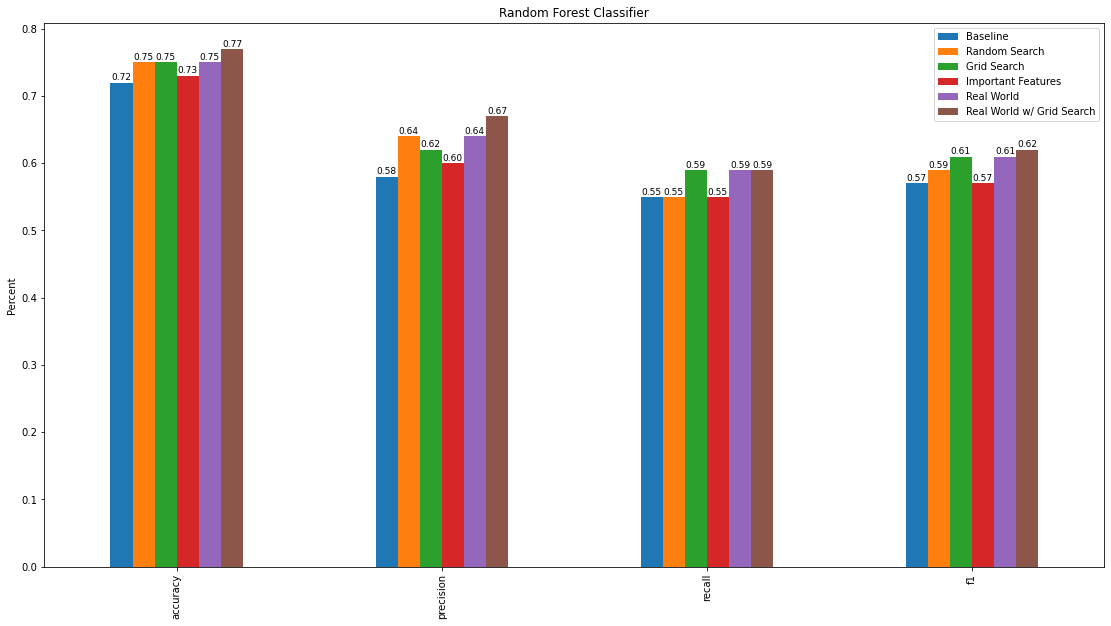

In [63]:
compare_rfc_metrics = pd.DataFrame({"Baseline": rfc_baseline,
                                  "Random Search": rfc_rs_metrics,
                                  "Grid Search" :rfc_gs_metrics,
                                  "Important Features": clf_important_metrics,
                                  "Real World": real_world_rfc_baseline_metrics,
                                   "Real World w/ Grid Search":gs_clf_real_world_metrics} )
%matplotlib inline
compare_rfc_models_bar = compare_rfc_metrics.plot.bar(figsize= (19,10),ylabel= "Percent", 
                                                      title= "Random Forest Classifier");

for bar in compare_rfc_models_bar.patches:
    compare_rfc_models_bar.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=9, xytext=(0, 5),
                   textcoords='offset points')

compare_rfc_models_bar;



**Checking if model is viable if we drop all records having missing values**

In [64]:
rfc_dropped_values_baseline = RandomForestClassifier()
rfc_dropped_values_baseline.fit(dropped_X_train,y_train)
dropped_baseline_y_preds = rfc_dropped_values.predict(dropped_X_test)

rfc_dropped_metrics = evaluate_preds(y_test,dropped_baseline_y_preds)


NameError: name 'rfc_dropped_values' is not defined

**Based on significant drop in all scoring metrics, I will not attempt to improve this model and will abandon removing records**

Below is a comparison of all RandomForestClassifier models attempted and their performance

In [65]:
compare_rfc_metrics = pd.DataFrame({"Baseline": rfc_baseline,
                                  "Random Search": rfc_rs_metrics,
                                  "Grid Search" :rfc_gs_metrics,
                                  "Important Features": clf_important_metrics,
                                  "Real World": real_world_rfc_baseline_metrics,
                                  "Real World w/ Grid Search":gs_clf_real_world_metrics,
                                  "Dropped records with null":rfc_dropped_metrics })
%matplotlib inline
#compare_rfc_metrics.plot.bar(figsize= (14,12));
#compare_rfc_metrics.plot(kind = "bar", title= "Random Forest Classifier comparison", figsize= (14,12));

compare_rfc_models_bar = compare_rfc_metrics.plot.bar(figsize= (20,12),ylabel= "Percent", 
                                                      title= "Random Forest Classifier");

for bar in compare_rfc_models_bar.patches:
    compare_rfc_models_bar.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=9, xytext=(0, 5),
                   textcoords='offset points')

compare_rfc_models_bar;

NameError: name 'rfc_dropped_metrics' is not defined

**Based on this, I will select the gridsearch model that used the mean imputation technique as the best performer for RandomForestClassifier**

In [66]:
best_rfc = gs_clf

## 4.2 Logistic Regression

In [67]:
from sklearn.linear_model import LogisticRegression

lreg_baseline = LogisticRegression()
lreg_baseline.fit(mean_X_train,y_train)

lreg_baseline_y_preds = lreg_baseline.predict(mean_X_test)

evaluate_preds(y_test,lreg_baseline_y_preds)




Accuracy: 74.68%
Precision: 0.64%
Recall: 0.53
F1: 0.58


{'accuracy': 0.75, 'precision': 0.64, 'recall': 0.53, 'f1': 0.58}

## 4.3 Naive Bayes




In [68]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB



In [69]:
gnb_baseline = GaussianNB()
gnb_baseline.fit(mean_X_train,y_train)

gnb_baseline_y_preds = gnb_baseline.predict(mean_X_test)

evaluate_preds(y_test,gnb_baseline_y_preds)

Accuracy: 76.62%
Precision: 0.67%
Recall: 0.59
F1: 0.62


{'accuracy': 0.77, 'precision': 0.67, 'recall': 0.59, 'f1': 0.62}

In [70]:
mnb_baseline = MultinomialNB()
mnb_baseline.fit(mean_X_train,y_train)

mnb_baseline_y_preds = mnb_baseline.predict(mean_X_test)

evaluate_preds(y_test,mnb_baseline_y_preds)


Accuracy: 61.69%
Precision: 0.41%
Recall: 0.37
F1: 0.39


{'accuracy': 0.62, 'precision': 0.41, 'recall': 0.37, 'f1': 0.39}

## 4.4 Gradient Boosting Classifier

In [71]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_baseline = GradientBoostingClassifier(n_estimators= 5000, max_depth = 5)
gbc_baseline.fit(mean_X_train,y_train)

gbc_baseline_y_preds = gbc_baseline.predict(mean_X_test)

evaluate_preds(y_test,gbc_baseline_y_preds)



Accuracy: 74.03%
Precision: 0.63%
Recall: 0.51
F1: 0.57


{'accuracy': 0.74, 'precision': 0.63, 'recall': 0.51, 'f1': 0.57}

In [72]:
gbc_tuned = GradientBoostingClassifier()
gbc_grid = {
        'n_estimators': [100, 250, 500],
        'max_depth': [1,3,5,7,9],
        'learning_rate': [0.001,0.01,.01,1]
     }
gs_gbc = GridSearchCV(gbc_tuned,gbc_grid,cv=5)
gs_gbc.fit(mean_X_train,y_train.values.ravel())





GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.01, 1],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [100, 250, 500]})

In [77]:
gs_mean_gbc_y_preds = gs_gbc.predict(mean_X_test)
gs_gbc.best_params_



gbc_gs_metrics = evaluate_preds(y_test,gs_mean_gbc_y_preds)



Accuracy: 74.03%
Precision: 0.68%
Recall: 0.41
F1: 0.51


In [76]:
gbc_real_world = GradientBoostingClassifier()
gbc_real_world.fit(real_world_mean_X_train,y_train)

gbc_real_world_y_preds = gbc_real_world.predict(real_world_mean_X_test)
evaluate_preds(y_test, gbc_real_world_y_preds)

Accuracy: 74.68%
Precision: 0.62%
Recall: 0.59
F1: 0.61


{'accuracy': 0.75, 'precision': 0.62, 'recall': 0.59, 'f1': 0.61}

# Saving Models

In [741]:
import pickle
pickle.dump(rfc_baseline, open("rfc_baseline.pkl", "wb"))
pickle.dump(rs_clf, open("rfc_rs.pkl", "wb"))
pickle.dump(gs_clf, open("rfc_gs.pkl", "wb"))
pickle.dump(clf_important, open("clf_important.pkl", "wb"))
pickle.dump(real_world_rfc_baseline, open("real_world_rfc_baseline.pkl", "wb"))
pickle.dump(gs_clf_real_world, open("gs_clf_real_world.pkl", "wb"))
pickle.dump(rfc_dropped_values_baseline, open("rfc_dropped.pkl", "wb"))
pickle.dump(gbc_baseline, open("gbc_baseline.pkl", "wb"))
pickle.dump(gs_gbc, open("gs_gbc.pkl", "wb"))
pickle.dump(gnb_baseline, open("gnb_baseline.pkl", "wb"))
pickle.dump(mnb_baseline, open("mnb_baseline.pkl", "wb"))
pickle.dump(lreg_baseline, open("lreg_baseline.pkl", "wb"))



In [742]:
pickle.dump(real_world_rfc_baseline, open("winning_model", "wb"))